In [ ]:
# !pip install --upgrade universal-portfolios 


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
from math import *
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import universal as up
from universal import tools, algos
from universal.algos import *
from statsmodels.tsa.arima.model import ARIMA

from cvxopt import solvers, matrix
solvers.options['show_progress'] = False

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16, 8)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# ignore logged warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

In [ ]:
djia = pd.read_csv('/content/drive/MyDrive/Диплом/djia.csv')
msci = pd.read_csv('/content/drive/MyDrive/Диплом/msci.csv')
nyse_n = pd.read_csv('/content/drive/MyDrive/Диплом/nyse-n.csv')
nyse_o = pd.read_csv('/content/drive/MyDrive/Диплом/nyse-o.csv')
sp500 = pd.read_csv('/content/drive/MyDrive/Диплом/sp500.csv')
tse = pd.read_csv('/content/drive/MyDrive/Диплом/tse.csv')

In [ ]:
data = {
        'djia' : djia,
        'msci' : msci,
        'nyse_n' : nyse_n,
        'nyse_o' : nyse_o,
        'sp500' : sp500,
        'tse' : tse 
}

In [ ]:
for key in data.keys():
    for i in range(1, len(data[key])):
        data[key].iloc[i, :] = data[key].iloc[i, :] * data[key].iloc[i-1, :]

In [ ]:
# plot = data['nyse_o'].iloc[:,:10].plot(title='nyse_o')
# plot.get_figure().savefig('nyse_o_10.jpeg')

In [ ]:
class CF_OGD:
    def __init__(self, dataset, window=5, eps=10, learning_rate=0):
        self.dataset = dataset
        self.dataset_shape = dataset.shape[1]
        self.window = window
        self.eps = eps
        self.learning_rate = learning_rate if learning_rate != 0 else 1/self.dataset_shape
        self.MA = lambda x, history:(history / x).mean(axis=0)
        # self.EMA = lambda alpha, x, history: self.algo_EMA(alpha, x, history) / x
        self.L1_median = lambda x, history:np.median(history, axis=0) / x
        self.algos_num = 6
        self.weights = self.weight_price_init()
        self.b = self.weight_b_init(dataset.shape[1])
        self.b_history = []
        self.S = []

    def weight_price_init(self):
        weight = np.ones(self.algos_num) / self.algos_num
        return weight.reshape(-1, 1) 

    def weight_b_init(self, num_columns):
        return np.ones(num_columns) / num_columns

    def algo_EMA(self, alpha, x, history):
        if len(history)==0:
          return x 
        else:
          return alpha*x + (1-alpha)*self.algo_EMA(alpha, history[-1], history[:-1])

    def predict_algos(self, x, history):
        x, history = x.values, history[-self.window:].values
        ma_pred = self.MA(x, history)
        ema1_pred = self.algo_EMA(0.1, x, history) / x
        ema2_pred = self.algo_EMA(0.3, x, history) / x
        ema3_pred = self.algo_EMA(0.6, x, history) / x
        ema4_pred = self.algo_EMA(0.8, x, history) / x
        median_pred = self.L1_median(x, history)

        preds = np.append([ma_pred * x], [ema1_pred * x], axis=0)
        preds = np.append(preds, [ema2_pred * x], axis=0)
        preds = np.append(preds, [ema3_pred * x], axis=0)
        preds = np.append(preds, [ema4_pred * x], axis=0)
        preds = np.append(preds, [median_pred * x], axis=0)
        return preds

    def predict_price_ogd(self, x, history):
        pred_algos = self.predict_algos(x, history)
        predict = pred_algos * self.weights

        return predict.sum(axis=0)

    def loss_grad(self, p_preds, p_true):
        step1 = p_preds.dot(p_preds.T)
        step2 = step1.dot(self.weights)
        step3 =  p_preds.dot(p_true.T)
        return step2 - step3

    def step_portfolio(self, x, history):
        pred_x = self.predict_price_ogd(x, history) / x.values

        x_mean = np.mean(pred_x)
        variable = min(0., np.dot(pred_x, self.b.T) - self.eps / np.linalg.norm(pred_x - x_mean)**2)

        # update portfolio
        b = self.b - variable * (pred_x - x_mean)
        self.b = tools.simplex_proj(b)
        
    def update_price_weights(self, loss):
        weight_update = self.weights - self.learning_rate * loss
        self.weights =  tools.simplex_proj(weight_update)

    def run(self):
        data = self.dataset
        for i in range(6, len(data)-1):
            x = data.iloc[i]
            history = data.iloc[(i-6):i]
            p_preds = model.predict_algos(x, history)

            if i == 6:
                self.S.append(1)
            else:
                S = self.S[-1]*np.dot(x.values/history.values[-1], self.b.T)
                self.S.append(S)

            model.step_portfolio(x, history)
            self.b_history.append(model.b)
            p_true = np.array([data.iloc[i+1].values])
            loss = model.loss_grad(p_preds, p_true)
            model.update_price_weights(loss)


In [ ]:
class CF_ONS:
    def __init__(self, dataset, window=5, eps=10, learning_rate=0):
        self.dataset = dataset
        self.dataset_shape = dataset.shape[1]
        self.window = window
        self.eps = eps

        self.learning_rate = learning_rate if learning_rate != 0 else 1/self.dataset_shape
        self.MA = lambda x, history:(history / x).mean(axis=0)
        # self.EMA = lambda alpha, x, history: self.algo_EMA(alpha, x, history) / x
        self.L1_median = lambda x, history:np.median(history, axis=0) / x
        self.algos_num = 6
        self.weights = self.weight_price_init()
        self.A = np.mat(np.eye(self.algos_num))
        self.b = self.weight_b_init(dataset.shape[1])
        self.b_history = []
        self.S = [1]

    def weight_price_init(self):
       weight = np.ones(self.algos_num) / self.algos_num
       return weight.reshape(-1, 1) 

    def weight_b_init(self, num_columns):
        return np.ones(num_columns) / num_columns

    def algo_EMA(self, alpha, x, history):
        if len(history)==0:
          return x 
        else:
          return alpha*x + (1-alpha)*self.algo_EMA(alpha, history[-1], history[:-1])

    def predict_algos(self, x, history):
        x, history = x.values, history[-self.window:].values
        ma_pred = self.MA(x, history)
        ema1_pred = self.algo_EMA(0.1, x, history) / x
        ema2_pred = self.algo_EMA(0.3, x, history) / x
        ema3_pred = self.algo_EMA(0.6, x, history) / x
        ema4_pred = self.algo_EMA(0.8, x, history) / x
        median_pred = self.L1_median(x, history)

        preds = np.append([ma_pred * x], [ema1_pred * x], axis=0)
        preds = np.append(preds, [ema2_pred * x], axis=0)
        preds = np.append(preds, [ema3_pred * x], axis=0)
        preds = np.append(preds, [ema4_pred * x], axis=0)
        preds = np.append(preds, [median_pred * x], axis=0)
        return preds

    def predict_price_ogd(self, x, history):
        pred_algos = self.predict_algos(x, history)
        # print(self.weights)
        predict = pred_algos * self.weights

        return predict.sum(axis=0)

    def loss_grad(self, p_preds, p_true):
        step1 = p_preds.dot(p_preds.T)
        step2 = step1.dot(self.weights)
        step3 =  p_preds.dot(p_true.T)
        return step2 - step3

    def step_portfolio(self, x, history):
        pred_x = self.predict_price_ogd(x, history) / x.values

        x_mean = np.mean(pred_x)
        variable = min(0., np.dot(pred_x, self.b.T) - self.eps / np.linalg.norm(pred_x - x_mean)**2)
        # update portfolio
        b = self.b - variable * (pred_x - x_mean)

        self.b = tools.simplex_proj(b)
        
    def update_price_weights(self, loss):
        self.A += loss * loss.T
        # projection of p induced by norm A
        weight_update = self.weights - self.learning_rate * self.A.I * loss

        self.weights =  self.projection_in_norm(weight_update, self.A)

    def projection_in_norm(self, x, M):
        """ 
        Projection of x to simplex indiced by matrix M. Uses quadratic programming.
        """
        m = M.shape[0]

        P = matrix(2*M)
        q = matrix(-2 * M * x)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros((m,1)))
        A = matrix(np.ones((1,m)))
        b = matrix(1.)

        sol = solvers.qp(P, q, G, h, A, b)
        return sol['x']

    def run(self):
        data = self.dataset
        for i in range(6, len(data)-1):
            x = data.iloc[i]
            history = data.iloc[(i-6):i]
            p_preds = model.predict_algos(x, history)

            if i == 6:
                self.S.append(1)
            else:
                S = self.S[-1]*np.dot(x.values/history.values[-1], self.b.T)
                self.S.append(S)

            model.step_portfolio(x, history)
            self.b_history.append(model.b)
            p_true = np.array([data.iloc[i+1].values])
            loss = model.loss_grad(p_preds, p_true)
            model.update_price_weights(loss)


In [ ]:
def plot_data_S(data):
  # Plot the data...
  fig = plt.figure(figsize=(16,8))
  ax = fig.add_subplot(111)
  ax.plot(list(map(log10, data)))

  plt.show()

In [ ]:
algos_OGD = {
        'djia' :   CF_OGD(dataset= data['djia']),
        'msci' :   CF_OGD(dataset= data['msci']),
        'nyse_n' : CF_OGD(dataset= data['nyse_n']),
        'nyse_o' : CF_OGD(dataset= data['nyse_o']),
        'sp500' :  CF_OGD(dataset= data['sp500']),
        'tse' :    CF_OGD(dataset= data['tse']) 
}

In [ ]:
algos_ONS = {
        'djia' :   CF_ONS(dataset= data['djia']),
        'msci' :   CF_ONS(dataset= data['msci']),
        'nyse_n' : CF_ONS(dataset= data['nyse_n']),
        'nyse_o' : CF_ONS(dataset= data['nyse_o']),
        'sp500' :  CF_ONS(dataset= data['sp500']),
        'tse' :    CF_ONS(dataset= data['tse']) 
}

score OGD djia:  2.403913133808748
score OGD msci:  21.160882692189602
score OGD nyse_n:  258731440.24698627
score OGD nyse_o:  3.519027218387584e+17
score OGD sp500:  9.200148155314622
score OGD tse:  309.5392351400481


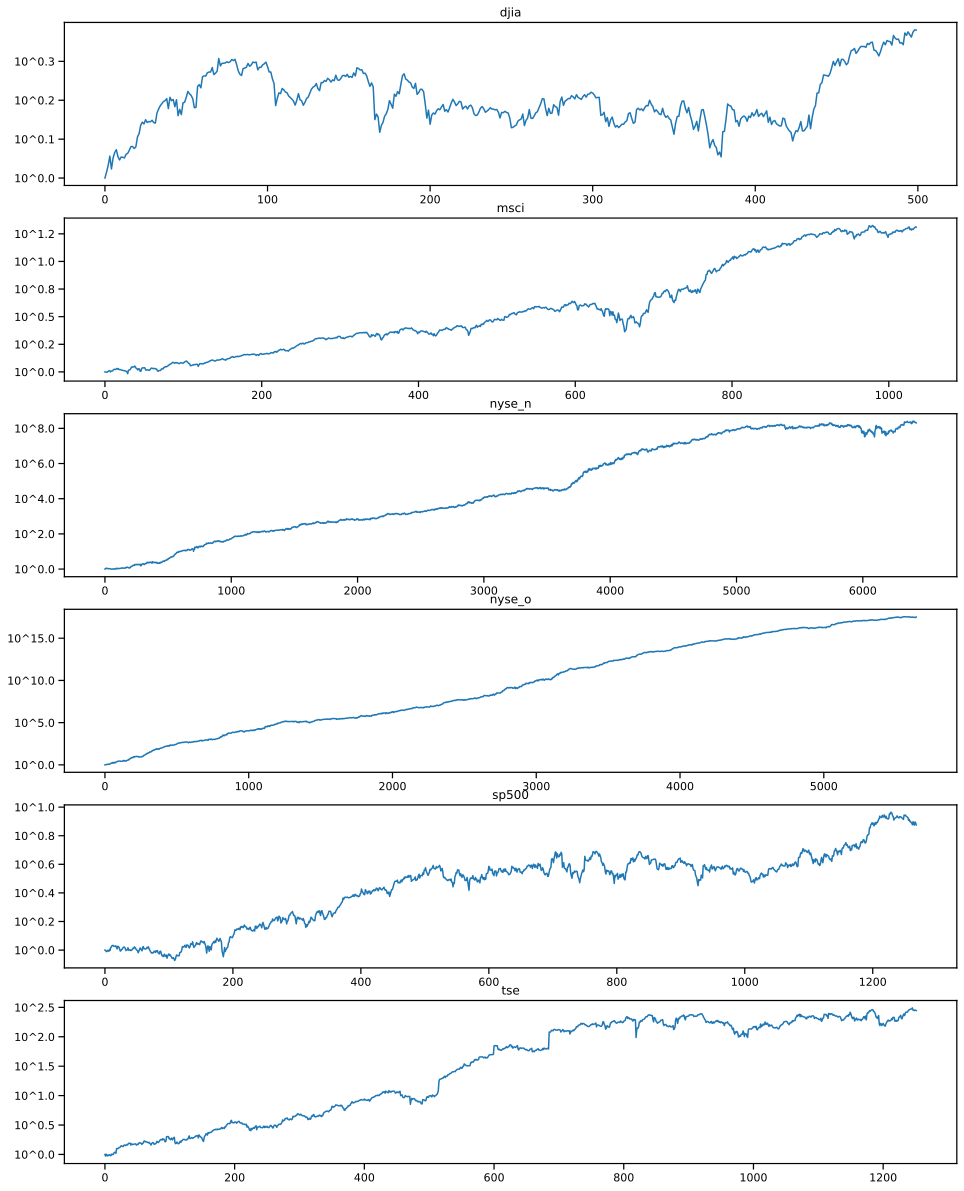

In [ ]:
fig, axs = plt.subplots(6, figsize=(16,21))
for i, key in enumerate(algos_OGD.keys()):   
    model = algos_OGD[key]
    model.run()
    print('score OGD %s: '% key, max(model.S))
    axs[i].set_title(key)
    axs[i].plot(list(map(log10, model.S)))
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('10^%.1f'))
    # axs[i%3, i%2].set_title(key)
    # axs[i%3, i%2].plot(list(map(log10, model.S)))
plt.show()
# plt.savefig('run_result_OGD.png')

score ONS djia:  2.364884838565375
score ONS msci:  19.635965799443905
score ONS nyse_n:  1283443621.716752
score ONS nyse_o:  1.0209440436281578e+18
score ONS sp500:  19.206799368456146
score ONS tse:  150.23468140364764


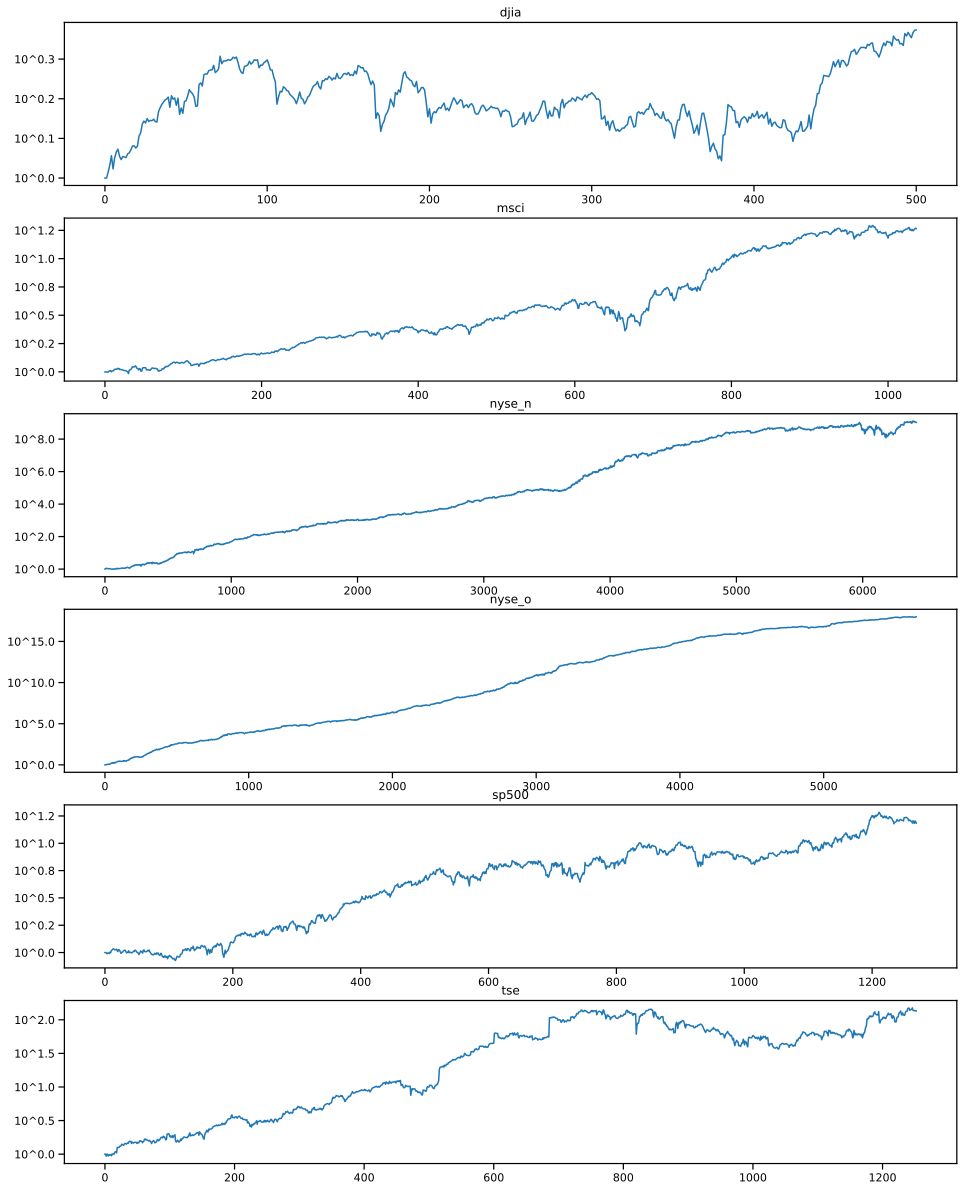

In [ ]:
fig, axs = plt.subplots(6, figsize=(16,21))
for i, key in enumerate(algos_ONS.keys()):   
    model = algos_ONS[key]
    model.run()
    print('score ONS %s: '% key, max(model.S))
    axs[i].set_title(key)
    axs[i].plot(list(map(log10, model.S)))
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('10^%.1f'))

# plt.show()
plt.savefig('run_result_ONS.png')